# Compute Classifier Metrics

Author: Jess Ewald

The classification pipeline now outputs the probability of the positive class for each cell profile, along with the labels and classifier info. This allows us to compute any metric of interest. Here, we compute possible metrics of interest:

- AUC-ROC
- macro-averaged F1 score
- balanced accuracy

And possible AUBPRC, where the positive class is defined as the less abundant one. 

In [123]:
# imports
import polars as pl
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from importlib import reload
import displayImages as di
reload(di)

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

In [43]:
# paths

res_b7 = "/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/results/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect"
res_b8 = "/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/results/2024_02_06_Batch_8/profiles_tcdropped_filtered_var_mad_outlier_featselect"
metrics_dir = "/dgx1nas1/storage/data/jess/varchamp/sc_data/classification_results/B7B8_1percent"
pm_dir = "/dgx1nas1/storage/data/jess/varchamp/platemaps"

In [57]:
# read in bb classifier info
info_b7 = pl.read_csv(f"{res_b7}/classifier_info.csv")
info_b7 = info_b7.with_columns(
    (pl.col("trainsize_1")/(pl.col("trainsize_0") + pl.col("trainsize_1"))).alias("train_prob_1"),
    (pl.col("testsize_1")/(pl.col("testsize_0") + pl.col("testsize_1"))).alias("test_prob_1"),
)

info_b8 = pl.read_csv(f"{res_b8}/classifier_info.csv")
info_b8 = info_b8.with_columns(
    (pl.col("trainsize_1")/(pl.col("trainsize_0") + pl.col("trainsize_1"))).alias("train_prob_1"),
    (pl.col("testsize_1")/(pl.col("testsize_0") + pl.col("testsize_1"))).alias("test_prob_1"),
)

info = pl.concat([info_b7, info_b8])

In [22]:
# classifier predictions
preds_b8 = pl.scan_parquet(f"{res_b8}/predictions.parquet")
preds_b8 = preds_b8.with_columns(
    pl.lit("batch8").alias("Batch")
).collect()

preds_b7 = pl.scan_parquet(f"{res_b7}/predictions.parquet")
preds_b7 = preds_b7.with_columns(
    pl.lit("batch7").alias("Batch")
).collect()


preds = pl.concat([preds_b7, preds_b8]).with_columns(
    pl.concat_str([pl.col("Classifier_ID"),
                   pl.col("Metadata_Protein"),
                   pl.col("Batch")],
                   separator="_").alias("Full_Classifier_ID")
)

In [81]:
# Define a function to compute metrics for each group
def compute_aubprc(auprc, prior):
    return (auprc*(1-prior))/((auprc*(1-prior)) + ((1-auprc)*prior))

def compute_metrics(group):
    y_true = group["Label"].to_numpy()
    y_prob = group["Prediction"].to_numpy()
    y_pred = (y_prob > 0.5).astype(int)
    prior = sum(y_true == 1)/len(y_true)
    
    class_ID = group["Classifier_ID"].unique()[0]

    # Compute AUROC
    auroc = roc_auc_score(y_true, y_prob)

    # Compute AUPRC
    auprc = average_precision_score(y_true, y_prob)
    aubprc = compute_aubprc(auprc, prior)

    # Compute macro-averaged F1 score
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    # Compute sensitivity and specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Compute balanced accuracy
    balanced_acc = balanced_accuracy_score(y_true, y_pred)

    return {
        "AUROC": auroc,
        "AUPRC": auprc,
        "AUBPRC": aubprc,
        "Macro_F1": macro_f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Balanced_Accuracy": balanced_acc,
        "Classifier_ID": class_ID
    }


In [83]:
# Initialize an empty list to store the results
results = []
classIDs = preds.select("Full_Classifier_ID").to_series().unique().to_list()

# Group by Classifier_ID and compute metrics for each group
for id in classIDs:
    metrics = compute_metrics(preds.filter(pl.col("Full_Classifier_ID") == id))
    metrics["Full_Classifier_ID"] = id
    results.append(metrics)

# Convert the results to a Polars DataFrame
metrics_df = pl.DataFrame(results)

# Add classifier info and save
metrics_df = metrics_df.join(info, on="Classifier_ID")
metrics_df = metrics_df.with_columns(
    (pl.max_horizontal(["trainsize_0", "trainsize_1"])/pl.min_horizontal(["trainsize_0", "trainsize_1"])).alias("Training_imbalance"),
    (pl.max_horizontal(["testsize_0", "testsize_1"])/pl.min_horizontal(["testsize_0", "testsize_1"])).alias("Testing_imbalance")
)
metrics_df.write_csv(f"{metrics_dir}/metrics.csv")

In [3]:
metrics_df = pl.read_csv(f"{metrics_dir}/metrics.csv")

<Figure size 1000x800 with 0 Axes>

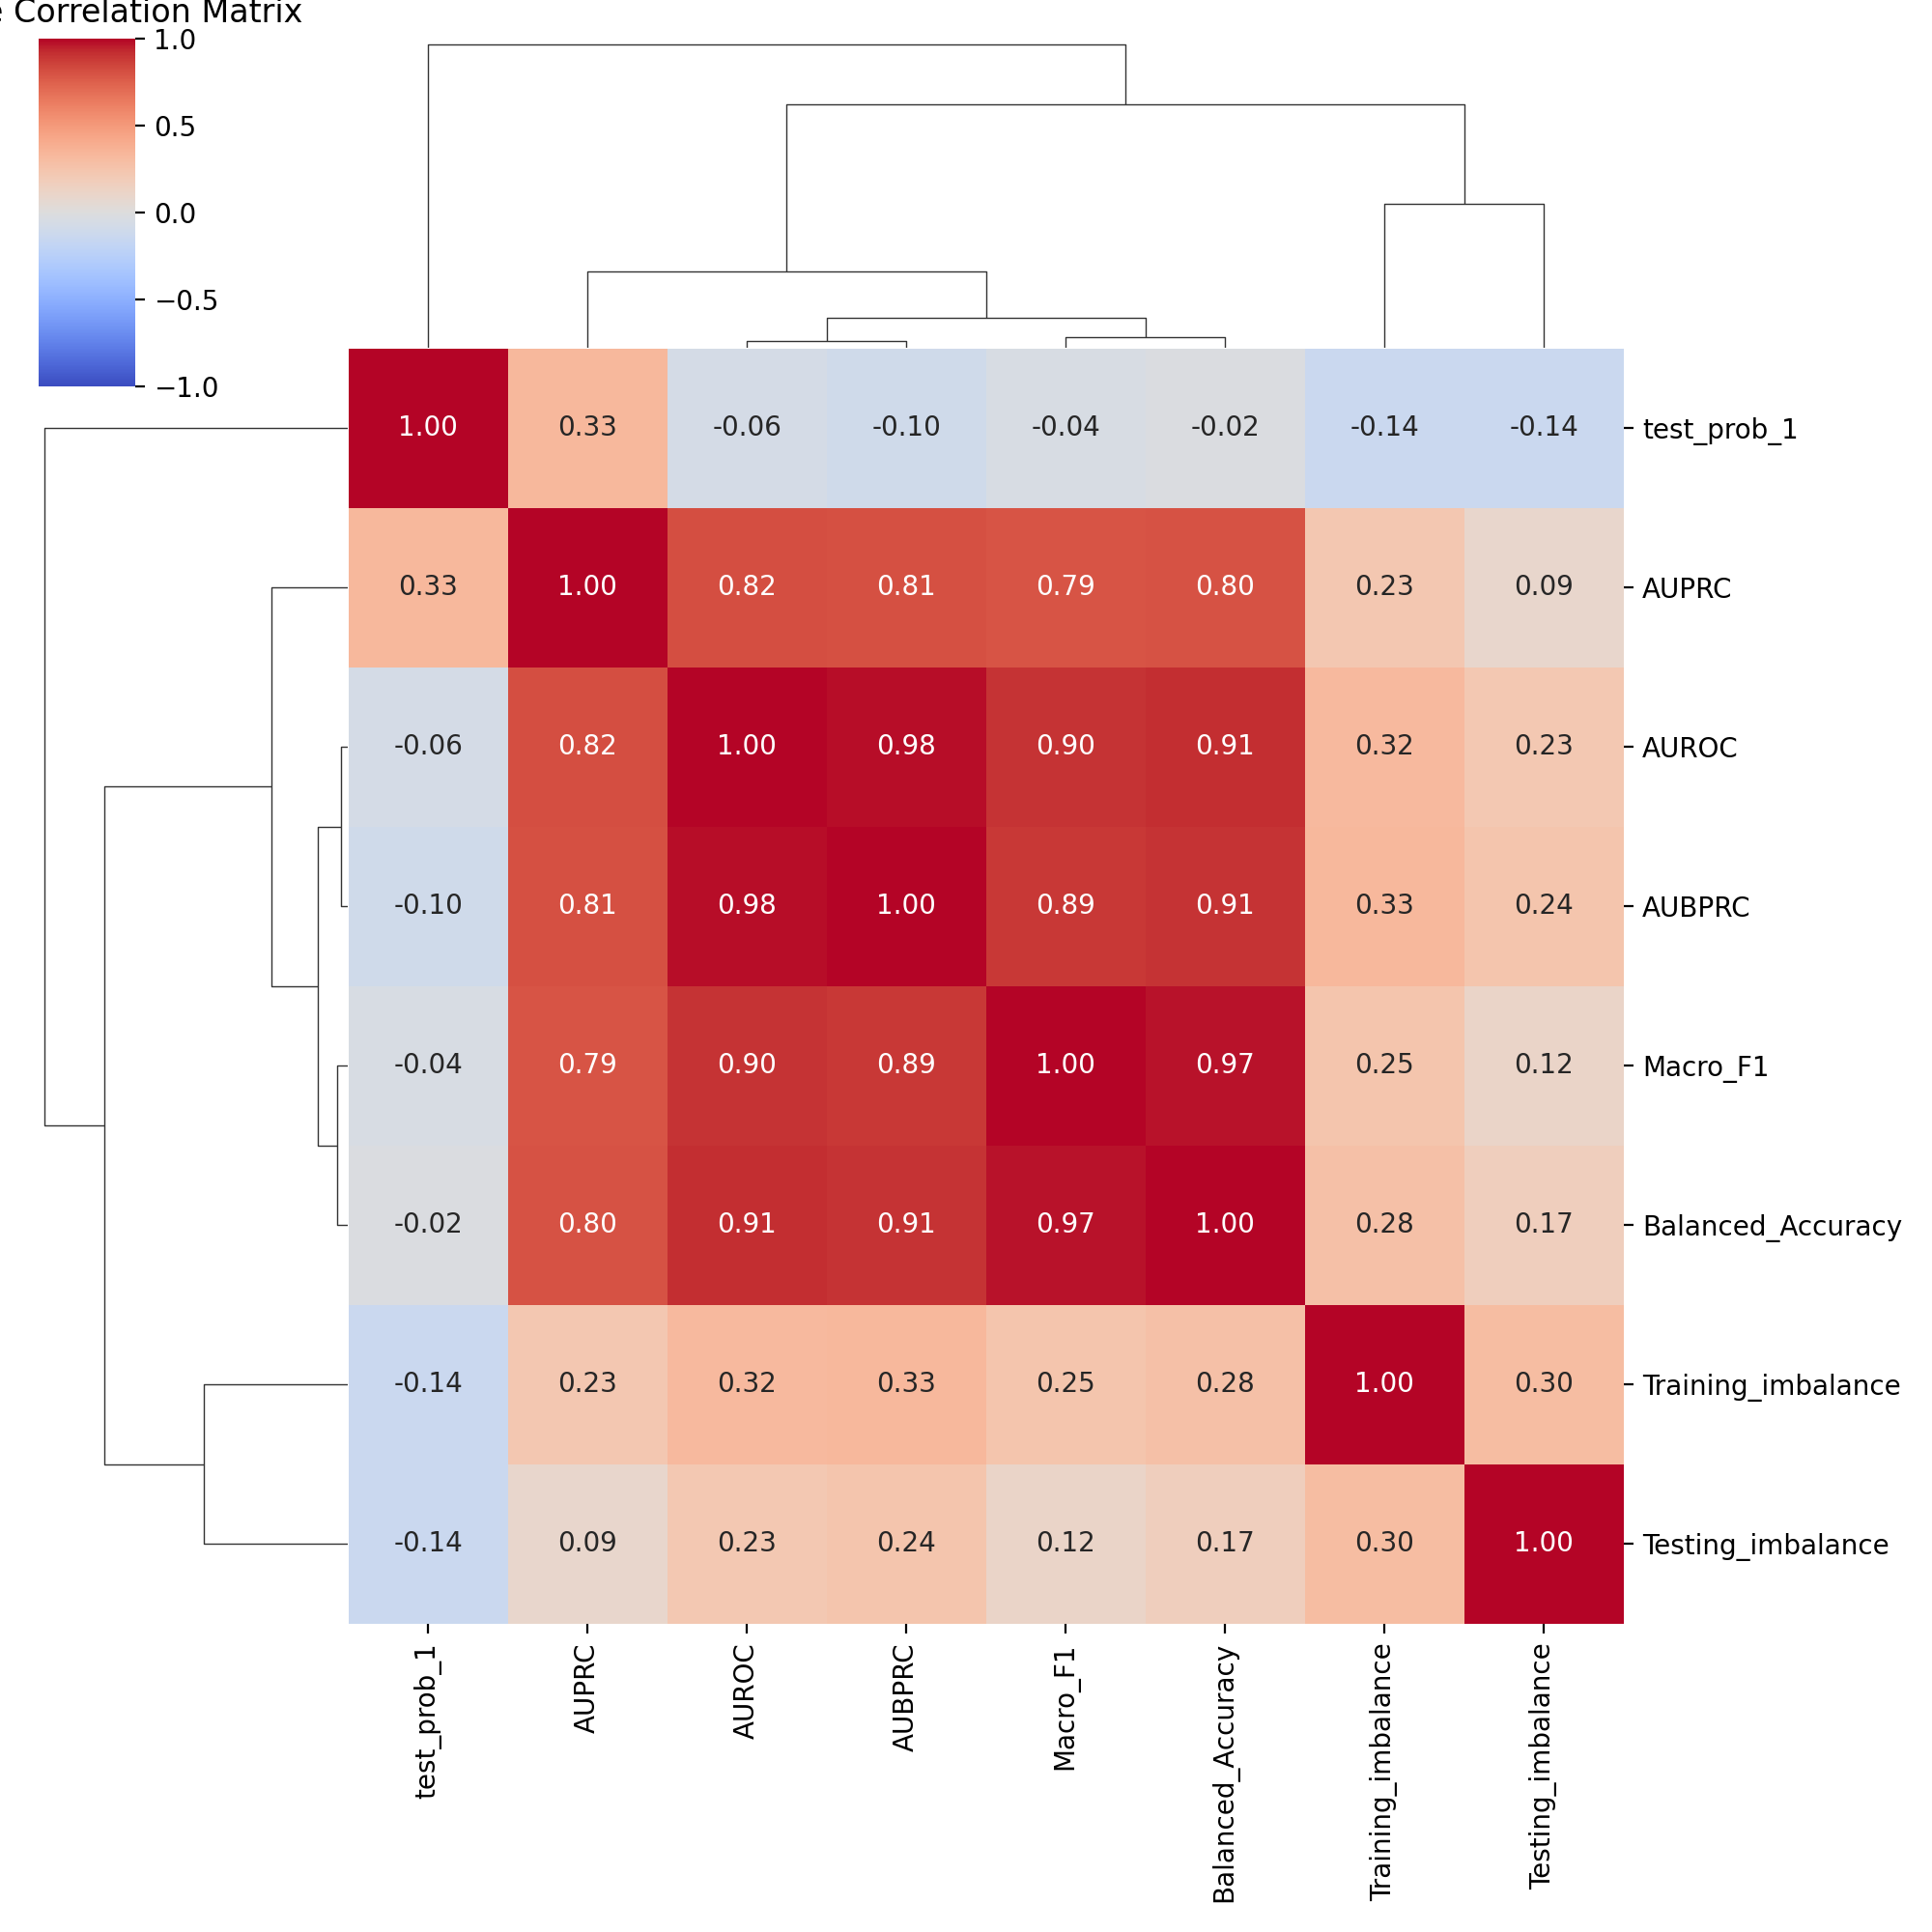

In [109]:
# Analyze pairwise correlation between metrics and test set imbalance
metrics_corr = metrics_df.select([
    'AUROC',
    'AUPRC',
    'AUBPRC',
    'Macro_F1',
    'Balanced_Accuracy',
    'test_prob_1',
    'Training_imbalance',
    'Testing_imbalance'
]).to_pandas().corr()

plt.figure(figsize=(10, 8))
sns.clustermap(metrics_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Pairwise Correlation Matrix")
plt.show()

All metrics are correlated with training imbalance and testing imbalance. The correlation is higher for the training imbalance. 

We do use the "scale_pos_weight" parameter, which is supposed to tell XGBoost to adjust it's weighting of the classes so that the majority class doesn't dominate the training. It's possible that this doesn't completely work and that this positive correlation is still indicative of the dominant class. 

However, I think that it's a different explanation: the single-cell features themselves are correlated with cell count simply based how increased cell density squishes cells, which greatly impacts morphology. Sometimes cell count is an inherently interesting phenomena (ie. toxicity impacts cell viability), however in our experimental set up, the cell count is primarily related to transfection efficiency, which is completely randomly distributed across different genetic perturbations. Therefore, it is a strong, biologically meaningless pattern that is consistent across both technical and biological replicates of each perturbation, making it a nasty confounding factor. Further, it is NOT controlled for by our CTRL-CTRL null because these compare two of the same perturbation and therefore they have the same transfection efficiency. The CTRL-CTRL classifiers are, on average, far more balanced than the WT-VAR classifiers.

One way to control: filter out classifiers that are very imbalanced (define cut-offs based on CTRL-CTRL balances) and only make inferences on the balanced ones. This is not ideal because it will involve throwing out WT-VAR pairs.

What would each cell look like if it wasn't squished?

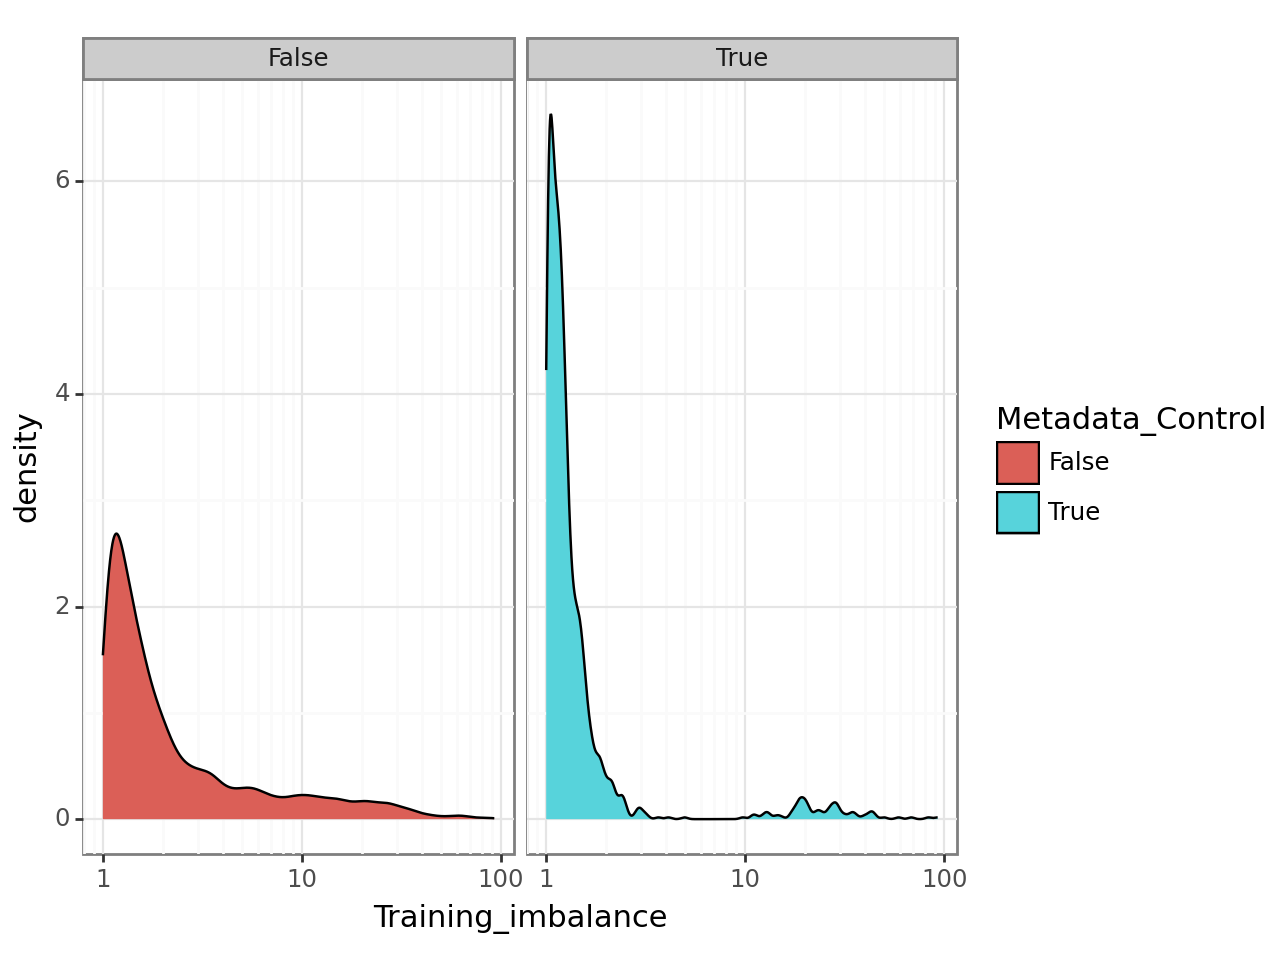

<Figure Size: (640 x 480)>

In [96]:
from plotnine import *

(ggplot(metrics_df, aes(x="Training_imbalance", fill="Metadata_Control"))
 + geom_density()
 + facet_wrap("Metadata_Control")
 + scale_x_log10()
 + theme_bw())

# This plot shows that in the training data, the controls (blue) are far more balanced than the WT-VAR (pink).
# To really prove that this is actual impact of density on features and not simply training class imbalance, I could downsample before training
# If the relationships hold, then we should still see the correlation between well cell count and classifier metrics.

In [156]:
imbalance_thresh = 5

print(metrics_df.shape)
print(metrics_df.filter(pl.col("Training_imbalance") < imbalance_thresh).shape)

print(len(metrics_df.select("allele_0").to_series().unique().to_list()))
print(len(metrics_df.filter(pl.col("Training_imbalance") < imbalance_thresh).select("allele_0").to_series().unique().to_list()))

(18908, 25)
(15858, 25)
1028
941


<Figure size 1000x800 with 0 Axes>

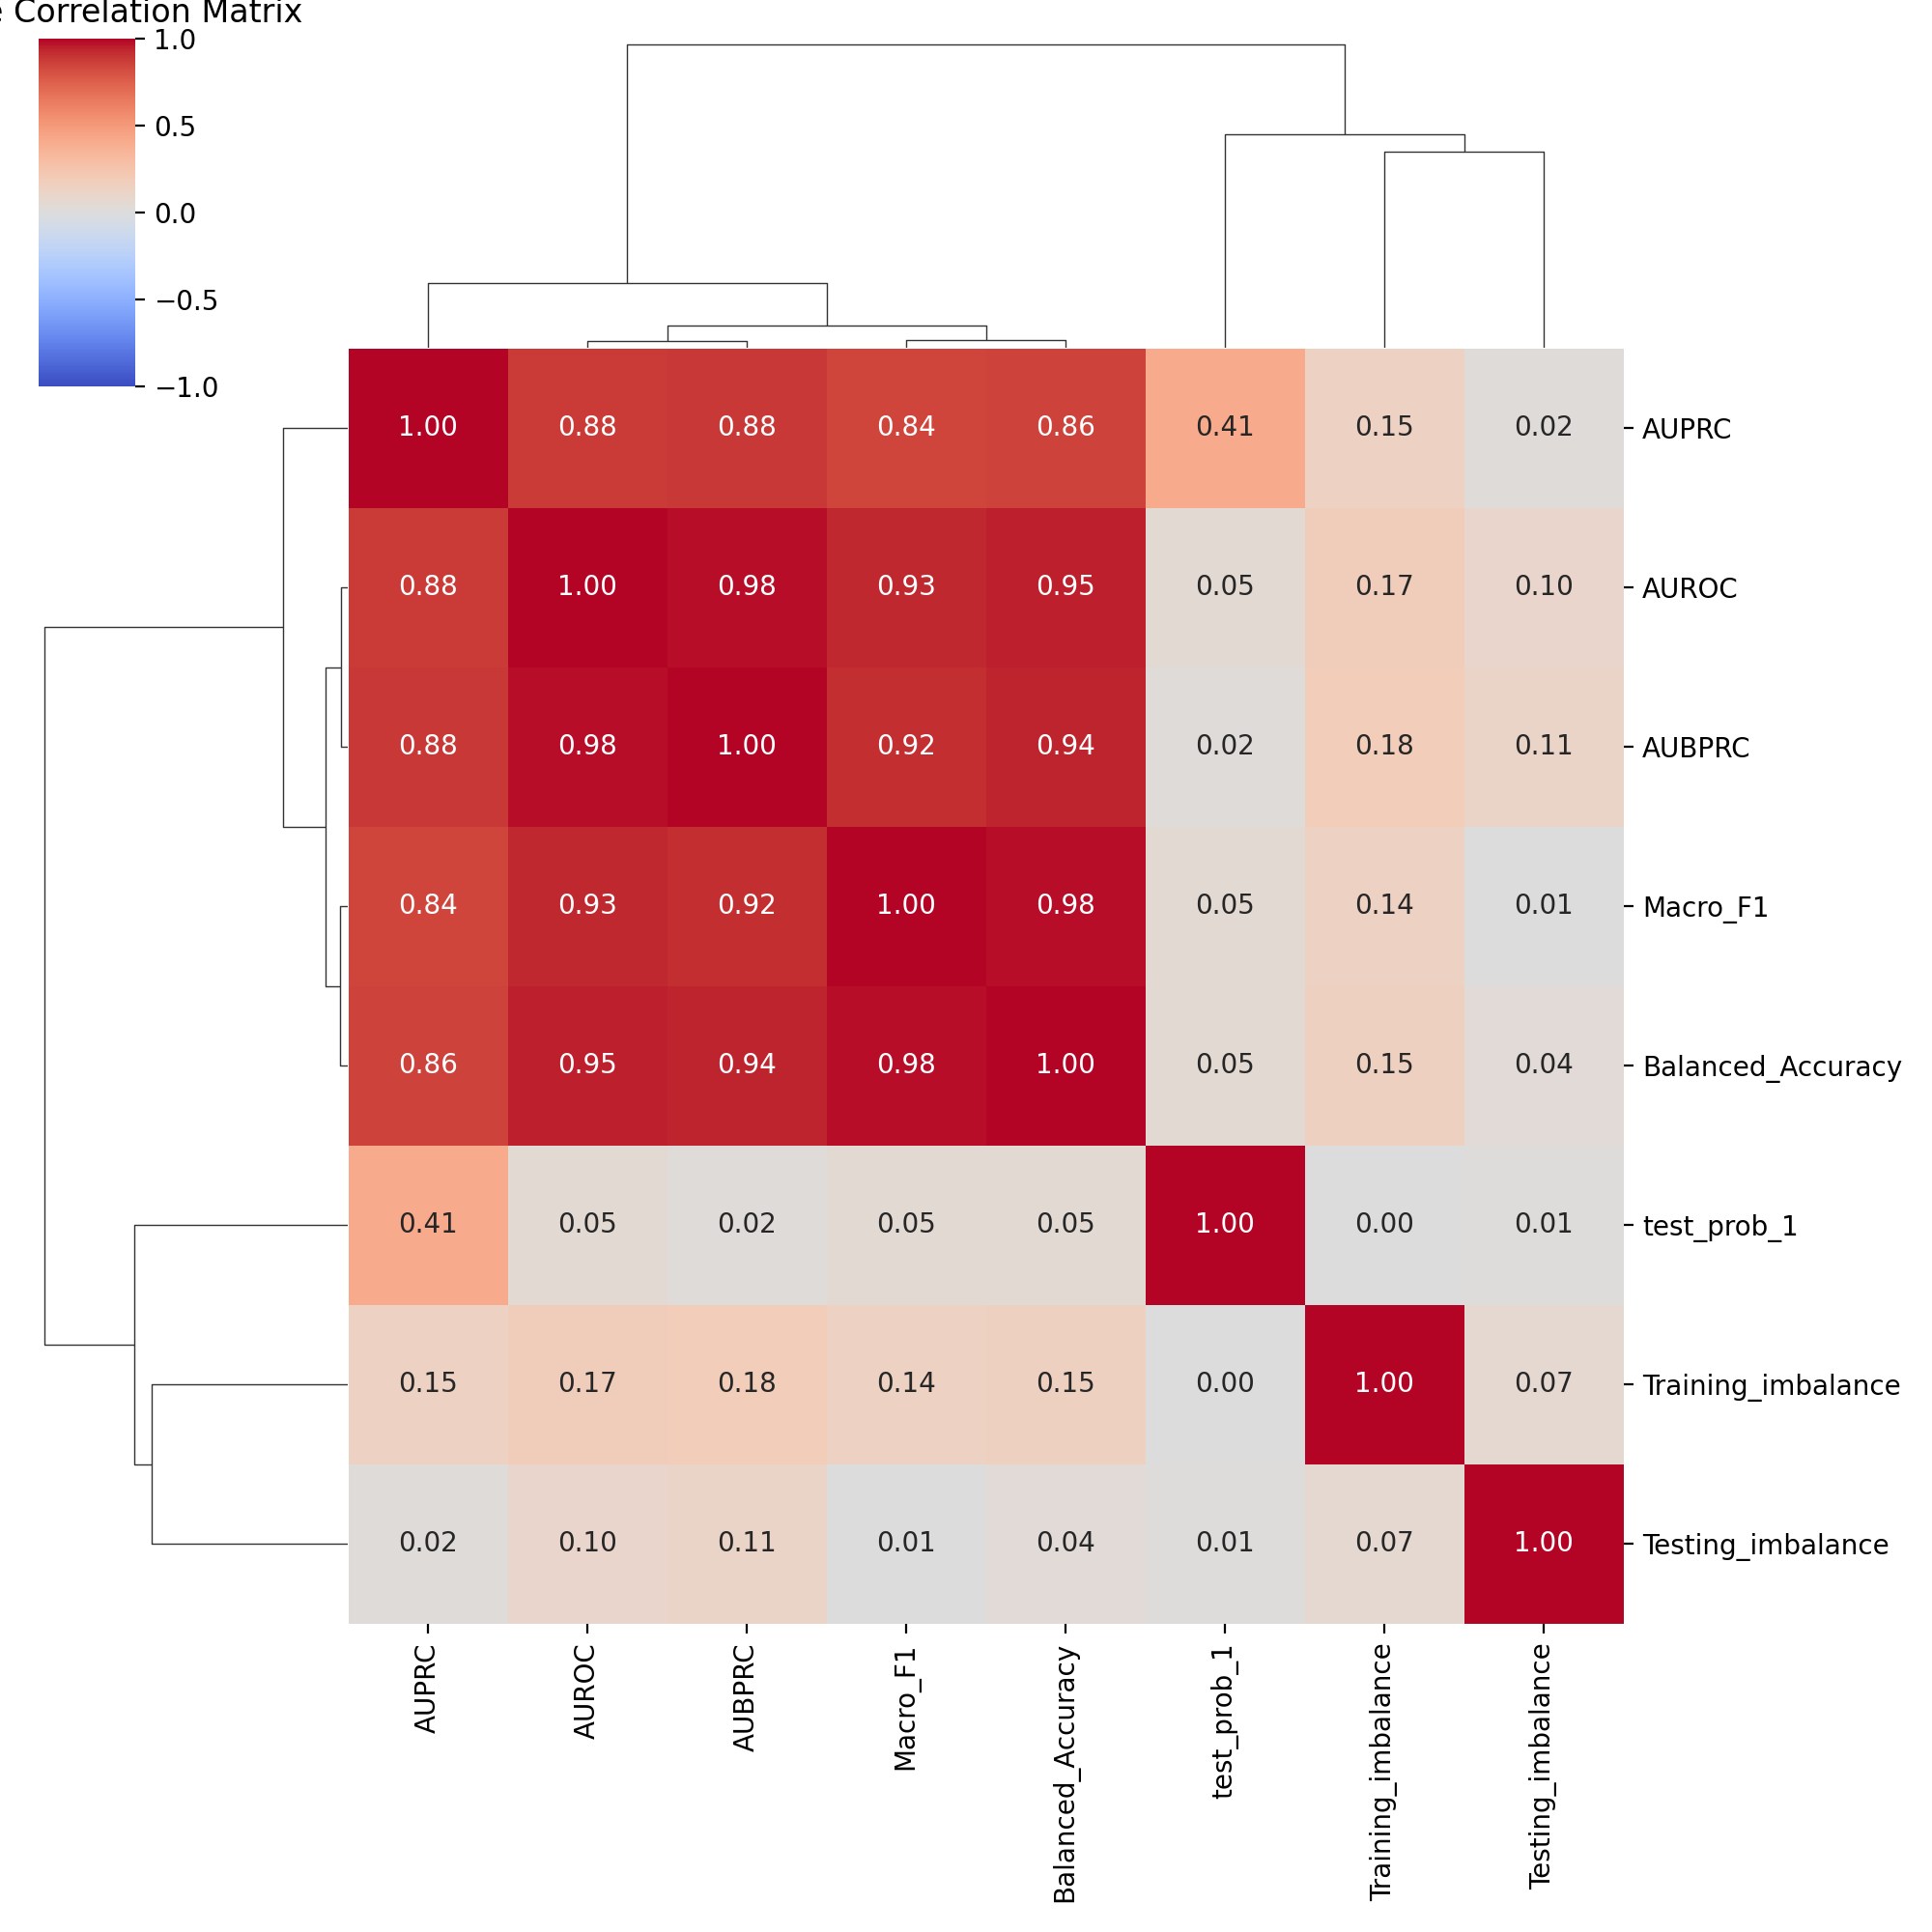

In [111]:
# Analyze pairwise correlation between metrics and test set imbalance
metrics_corr = metrics_df.filter(pl.col("Training_imbalance") < imbalance_thresh).select([
    'AUROC',
    'AUPRC',
    'AUBPRC',
    'Macro_F1',
    'Balanced_Accuracy',
    'test_prob_1',
    'Training_imbalance',
    'Testing_imbalance'
]).to_pandas().corr()

plt.figure(figsize=(10, 8))
sns.clustermap(metrics_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Pairwise Correlation Matrix")
plt.show()

Next, look at metrics across replicates within each batch, and also across batches (compare metrics aggregated across replicates). 

In [4]:
metrics_df = metrics_df.with_columns(
    pl.when(pl.col("Full_Classifier_ID").str.contains("true"))
    .then(pl.lit("localization"))
    .otherwise(pl.lit("morphology")).alias("Classifier_type"),
    pl.when(pl.col("Full_Classifier_ID").str.contains("B7A"))
    .then(pl.lit("batch7"))
    .otherwise(pl.lit("batch8")).alias("Batch"),
)

In [144]:
metrics_summary = metrics_df.select([
 'AUROC',
 'AUPRC',
 'AUBPRC',
 'Macro_F1',
 'Balanced_Accuracy',
 'Classifier_type',
 'Metadata_Control',
 'allele_0',
 'Batch'
]).group_by([ 'Classifier_type','Metadata_Control','allele_0','Batch']).agg([
    pl.all().exclude(['Classifier_type', 'Metadata_Control', 'allele_0', 'Batch']).mean().suffix('_mean'),
    pl.all().exclude(['Classifier_type', 'Metadata_Control', 'allele_0', 'Batch']).median().suffix('_median')
]).with_columns(pl.col("Metadata_Control").cast(pl.String).alias("Metadata_Control"))

In [145]:
metrics_summary = metrics_summary.melt(id_vars=['Classifier_type', 'Metadata_Control', 'allele_0', 'Batch'],
                                        value_vars=[col for col in metrics_summary.columns if col not in ['Classifier_type', 'Metadata_Control', 'allele_0', 'Batch']],
                                        value_name="Value",
                                        variable_name="Metric").pivot(
                                            index=['Classifier_type', 'Metadata_Control', 'allele_0', 'Metric'], 
                                            columns='Batch',
                                            values='Value')

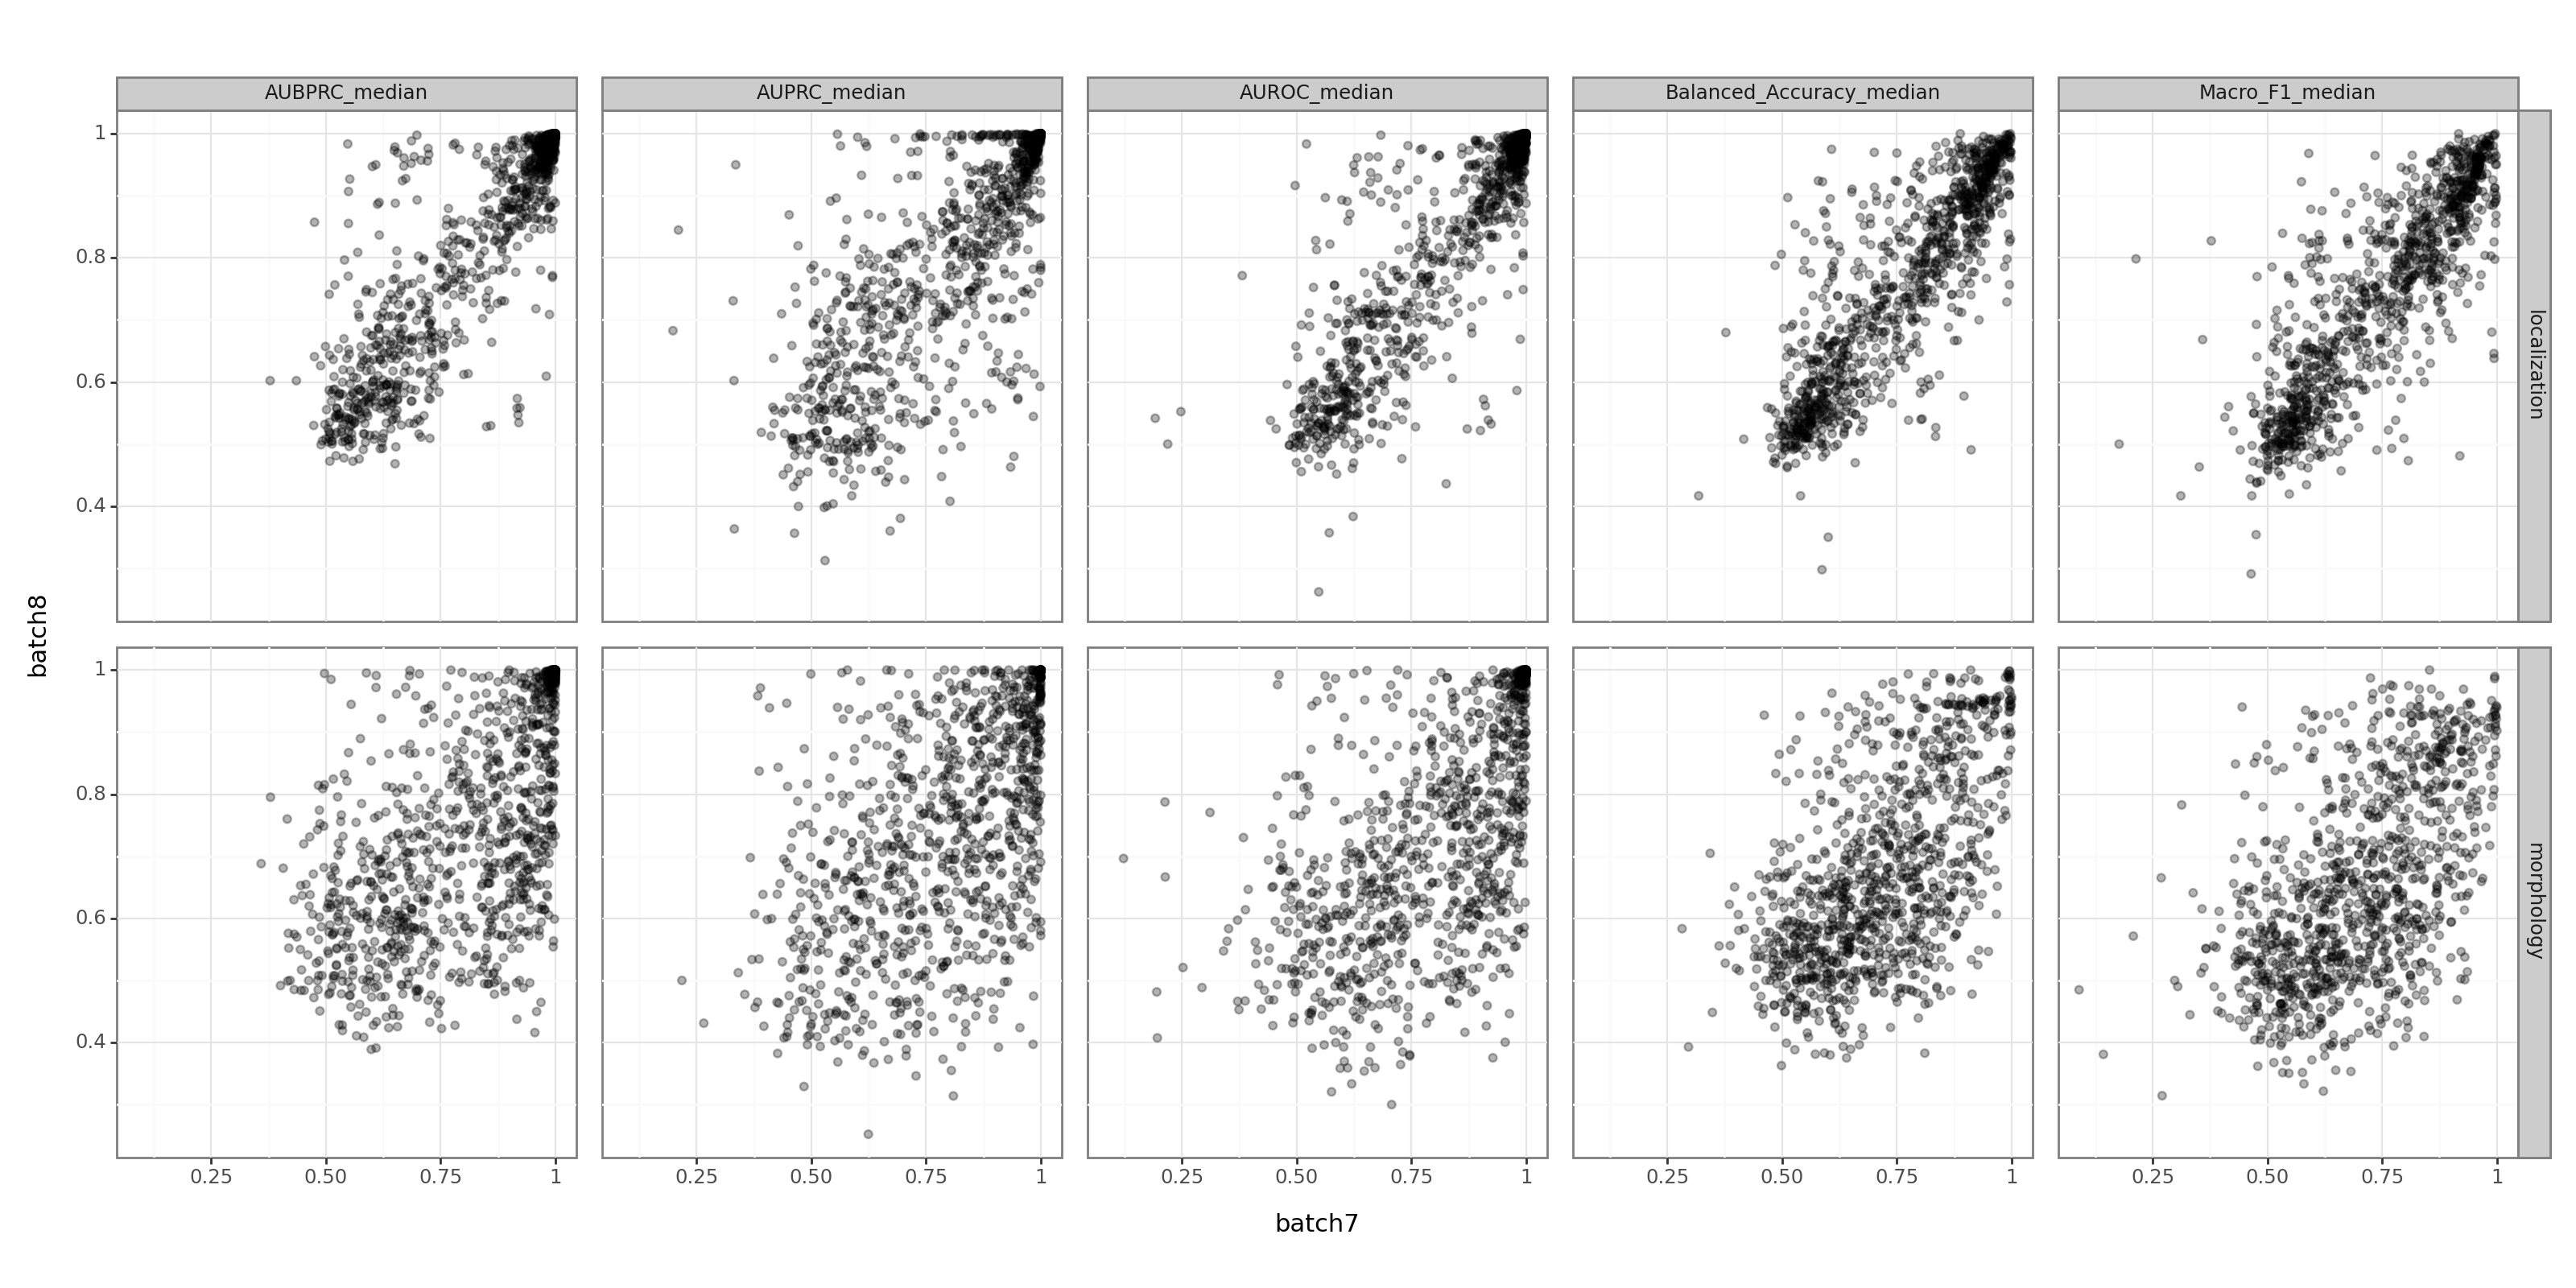

<Figure Size: (1600 x 800)>

In [146]:
import plotnine as plotnine
plotnine.options.figure_size = (16, 8)
(ggplot(metrics_summary.filter(pl.col("Metric").str.contains("median")), aes(x="batch7", y="batch8"))
 + geom_point(alpha=0.3)
 + theme_bw()
 + facet_grid("Classifier_type ~ Metric", "free"))

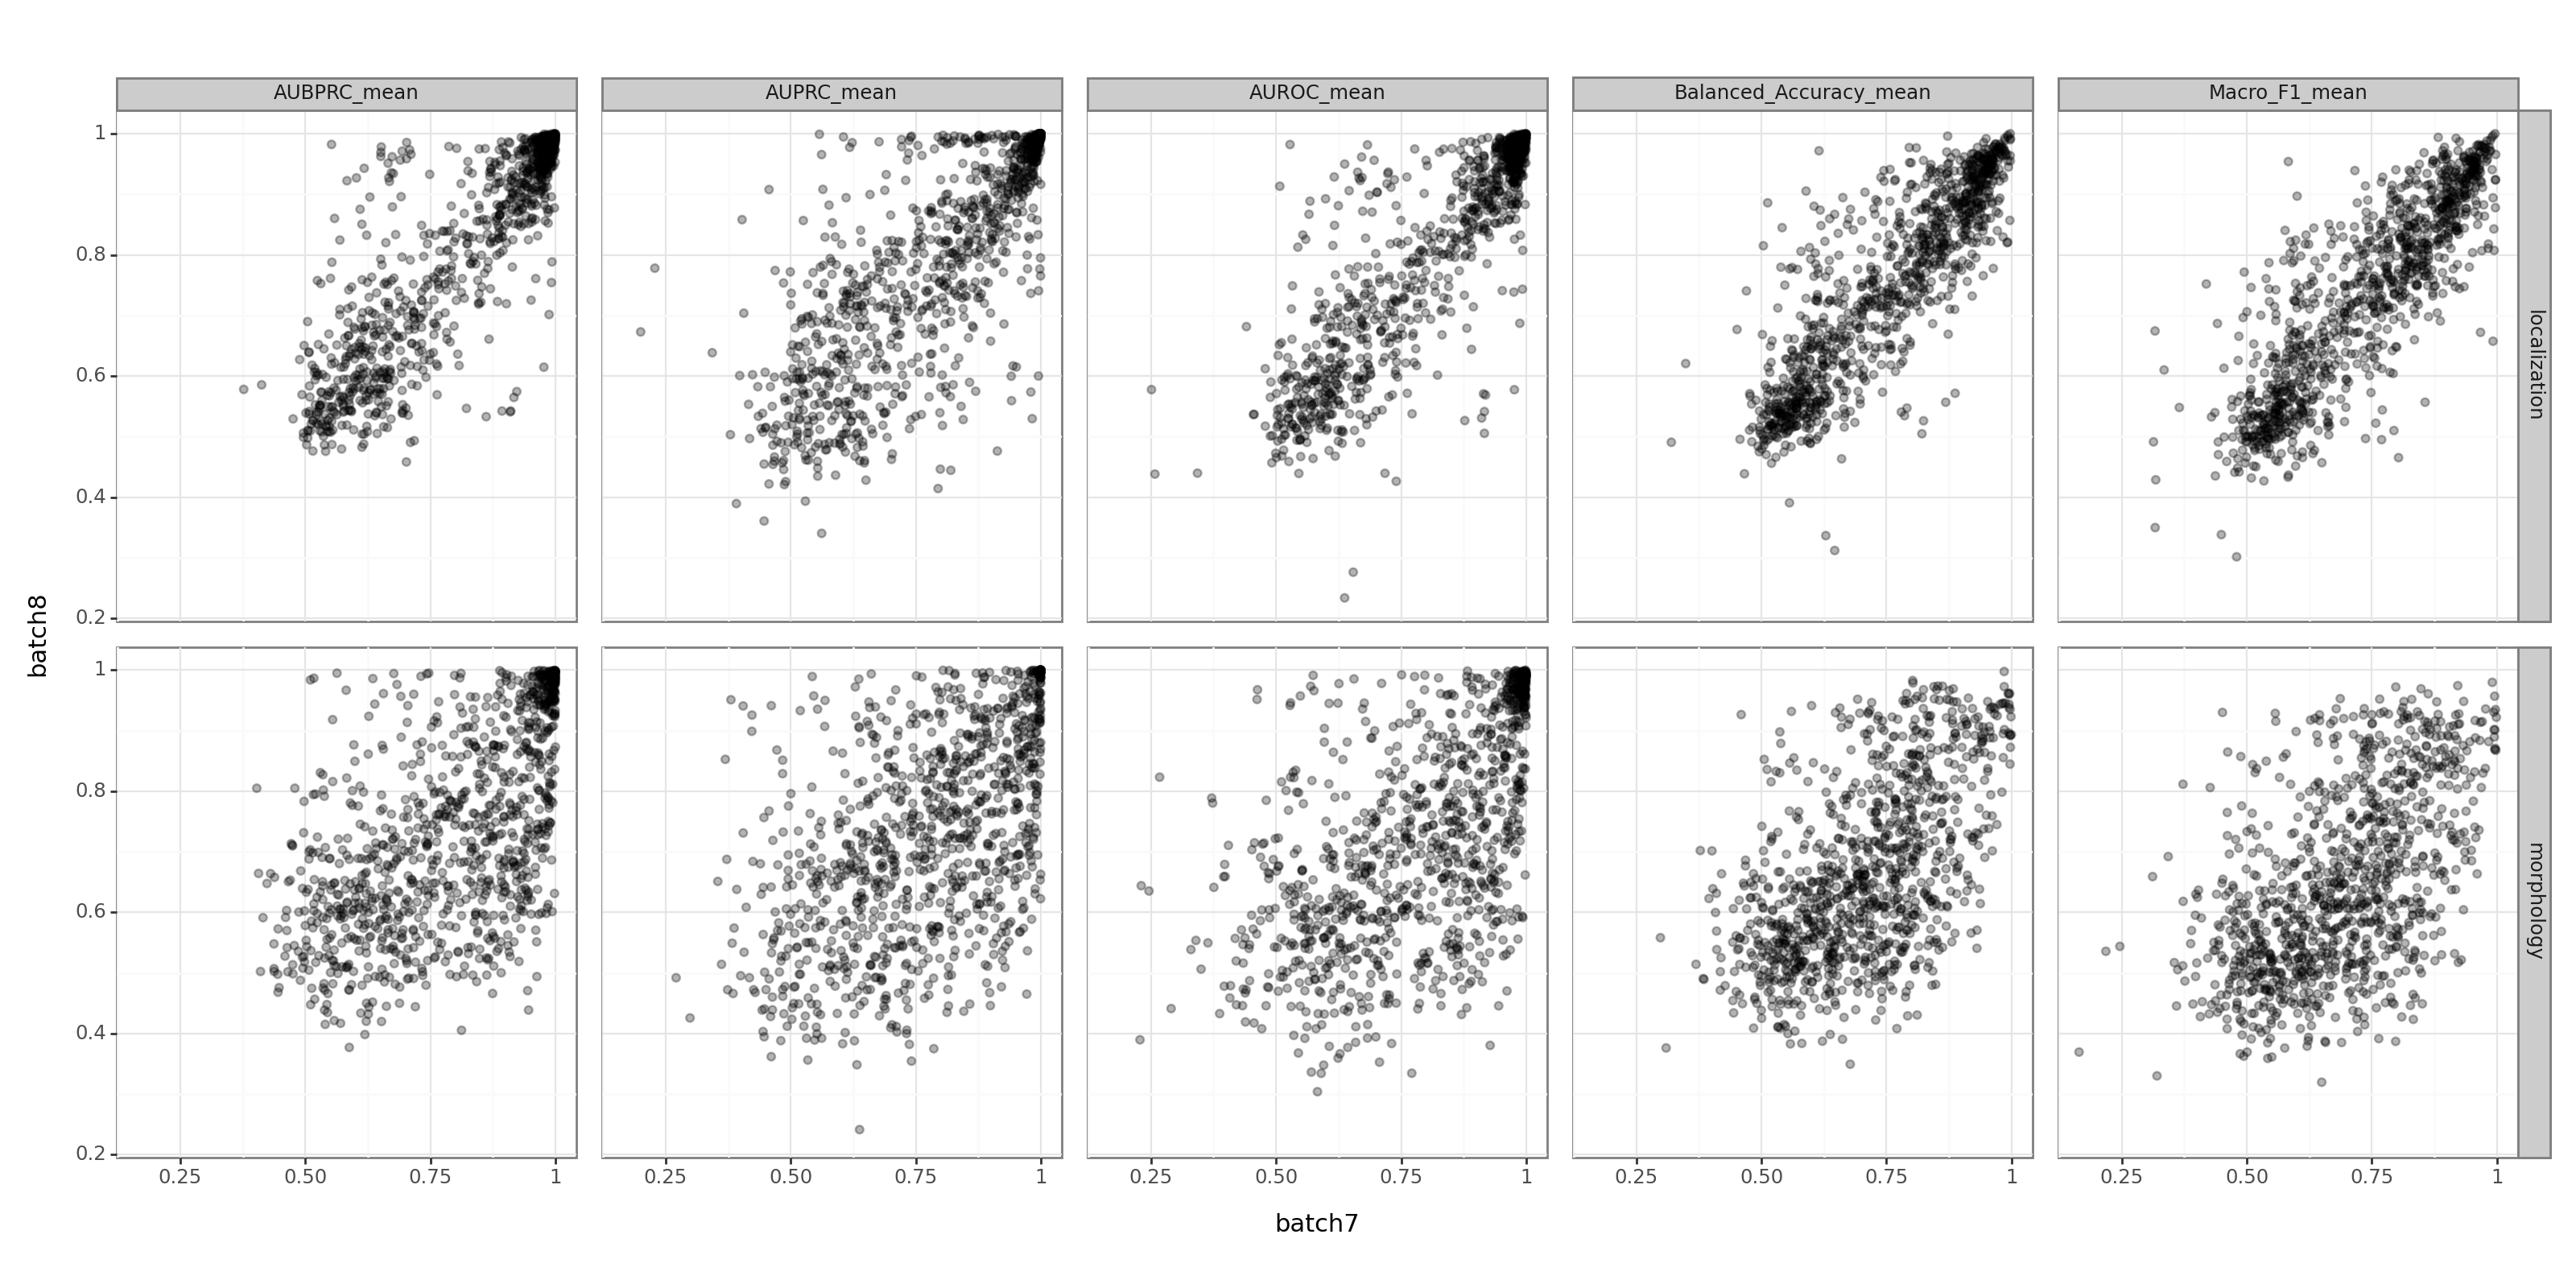

<Figure Size: (1600 x 800)>

In [147]:
plotnine.options.figure_size = (16, 8)
(ggplot(metrics_summary.filter(pl.col("Metric").str.contains("mean")), aes(x="batch7", y="batch8"))
 + geom_point(alpha=0.3)
 + theme_bw()
 + facet_grid("Classifier_type ~ Metric", "free"))

In [153]:
# try after filtering based on imbalance
metrics_summary = metrics_df.filter(pl.col("Training_imbalance") < 5).select([
 'AUROC',
 'AUPRC',
 'AUBPRC',
 'Macro_F1',
 'Balanced_Accuracy',
 'Classifier_type',
 'Metadata_Control',
 'allele_0',
 'Batch'
]).group_by([ 'Classifier_type','Metadata_Control','allele_0','Batch']).agg([
    pl.all().exclude(['Classifier_type', 'Metadata_Control', 'allele_0', 'Batch']).mean().suffix('_mean'),
    pl.all().exclude(['Classifier_type', 'Metadata_Control', 'allele_0', 'Batch']).median().suffix('_median')
]).with_columns(pl.col("Metadata_Control").cast(pl.String).alias("Metadata_Control"))

metrics_summary = metrics_summary.melt(id_vars=['Classifier_type', 'Metadata_Control', 'allele_0', 'Batch'],
                                        value_vars=[col for col in metrics_summary.columns if col not in ['Classifier_type', 'Metadata_Control', 'allele_0', 'Batch']],
                                        value_name="Value",
                                        variable_name="Metric").pivot(
                                            index=['Classifier_type', 'Metadata_Control', 'allele_0', 'Metric'],  # Preserving these columns as indexes
                                            columns='Batch',
                                            values='Value')


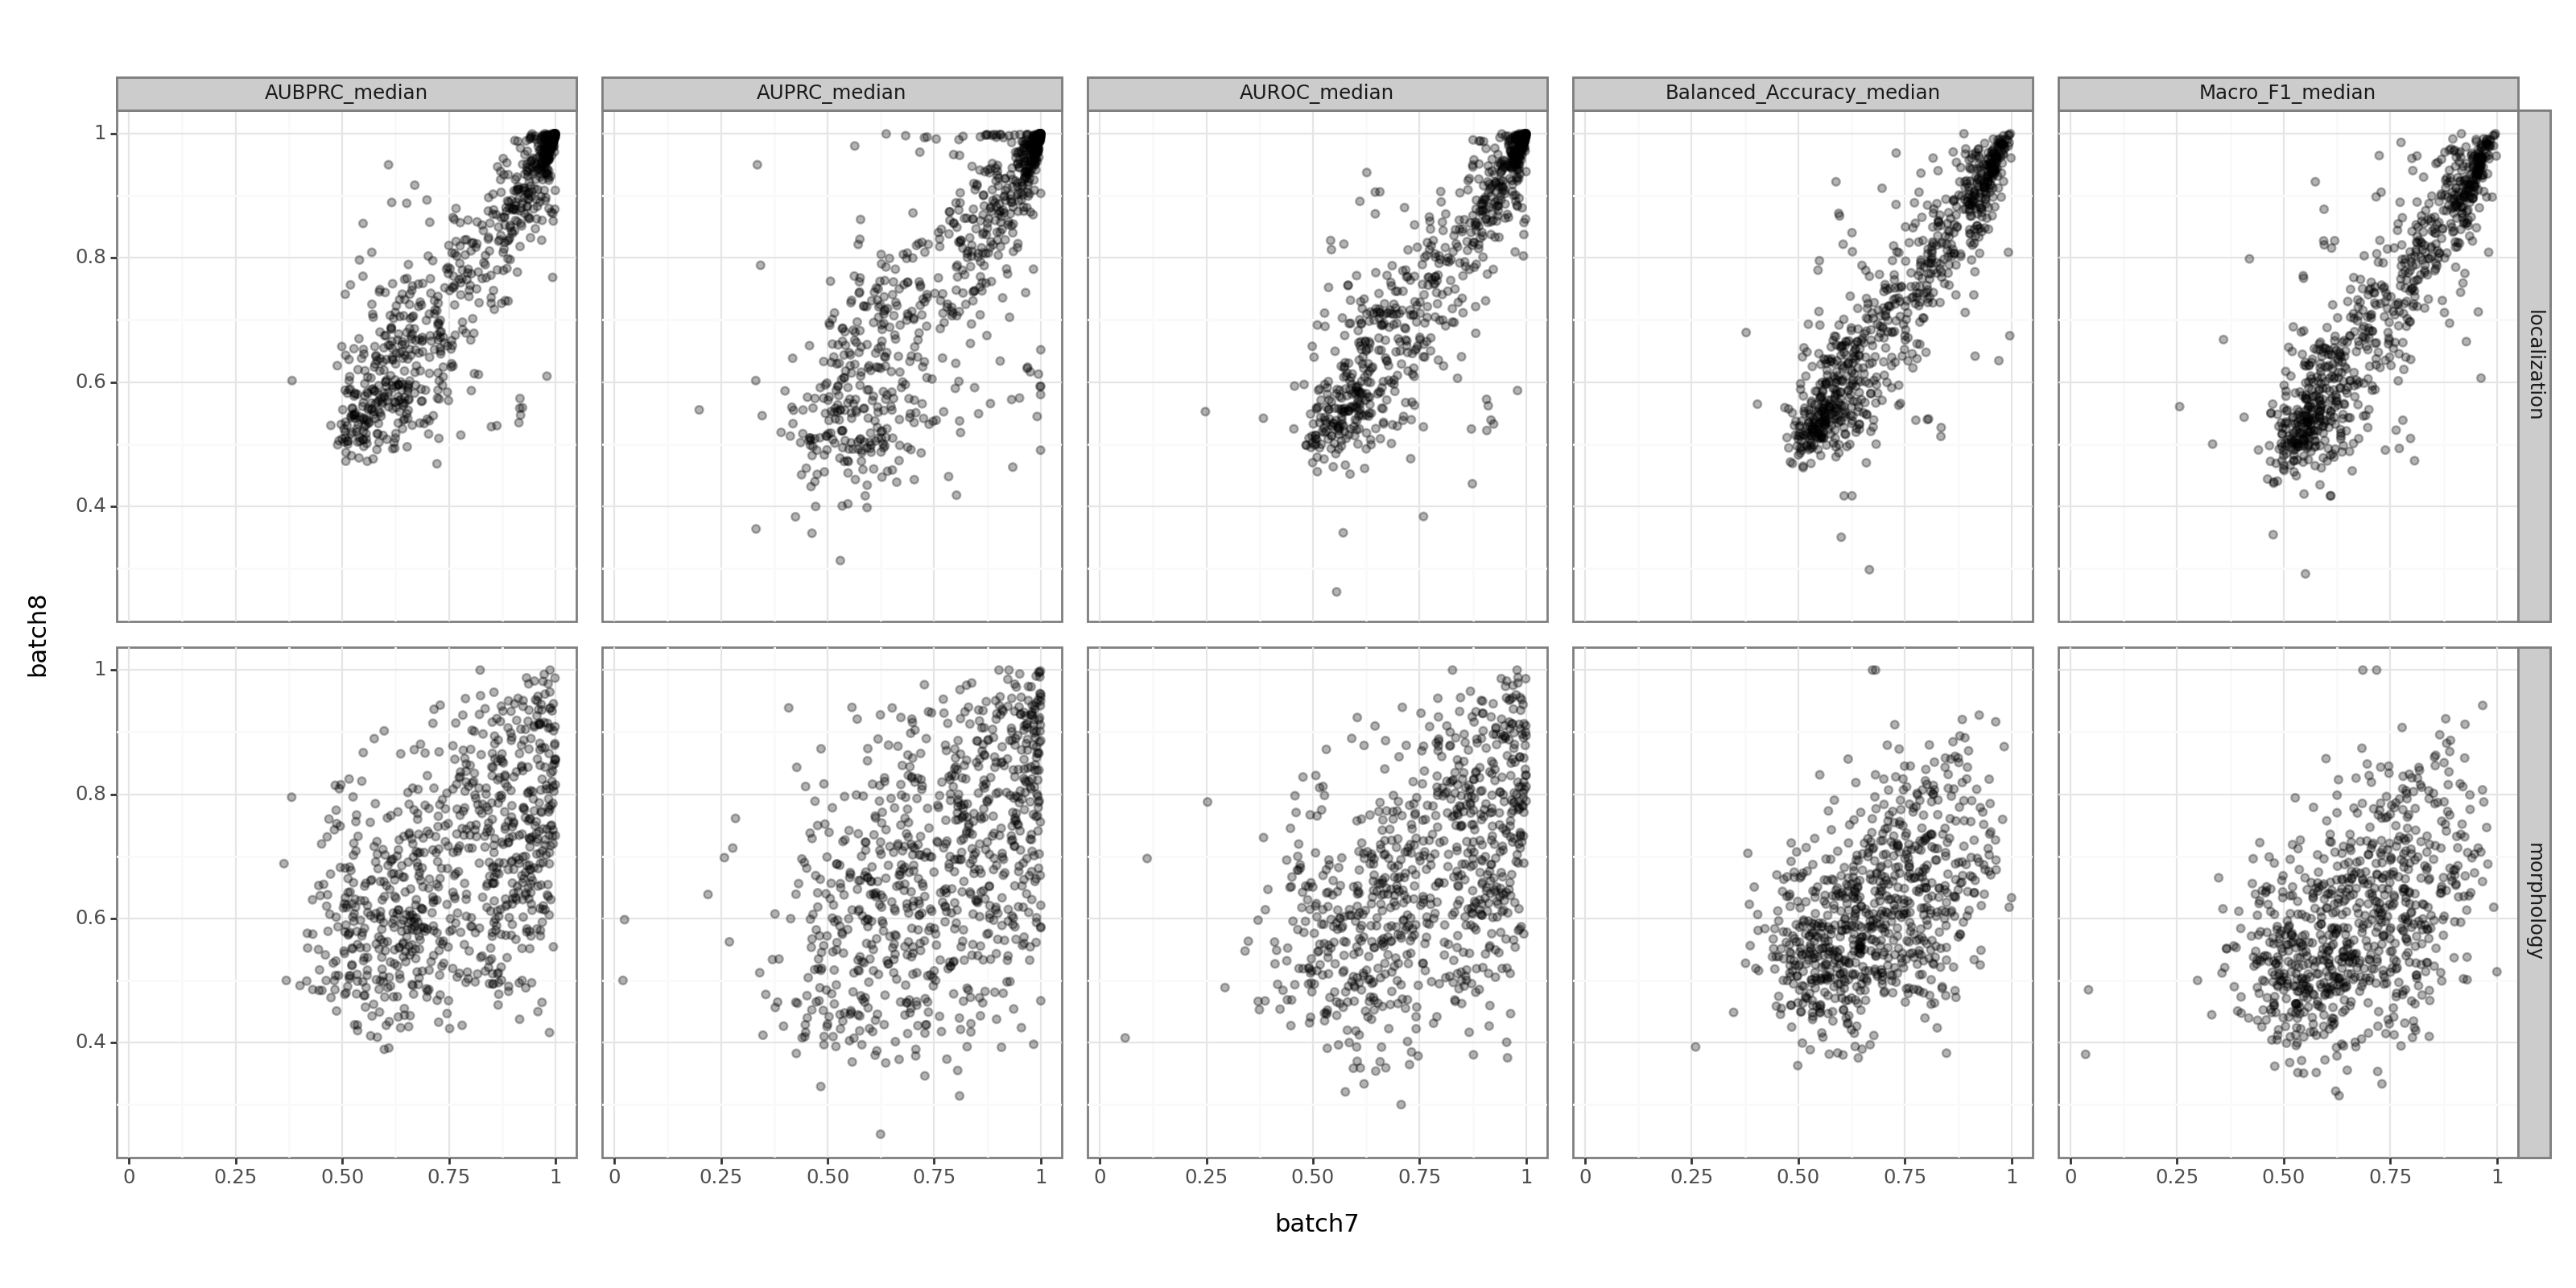

<Figure Size: (1600 x 800)>

In [154]:

plotnine.options.figure_size = (16, 8)
(ggplot(metrics_summary.filter(pl.col("Metric").str.contains("median")), aes(x="batch7", y="batch8"))
 + geom_point(alpha=0.3)
 + theme_bw()
 + facet_grid("Classifier_type ~ Metric", "free"))

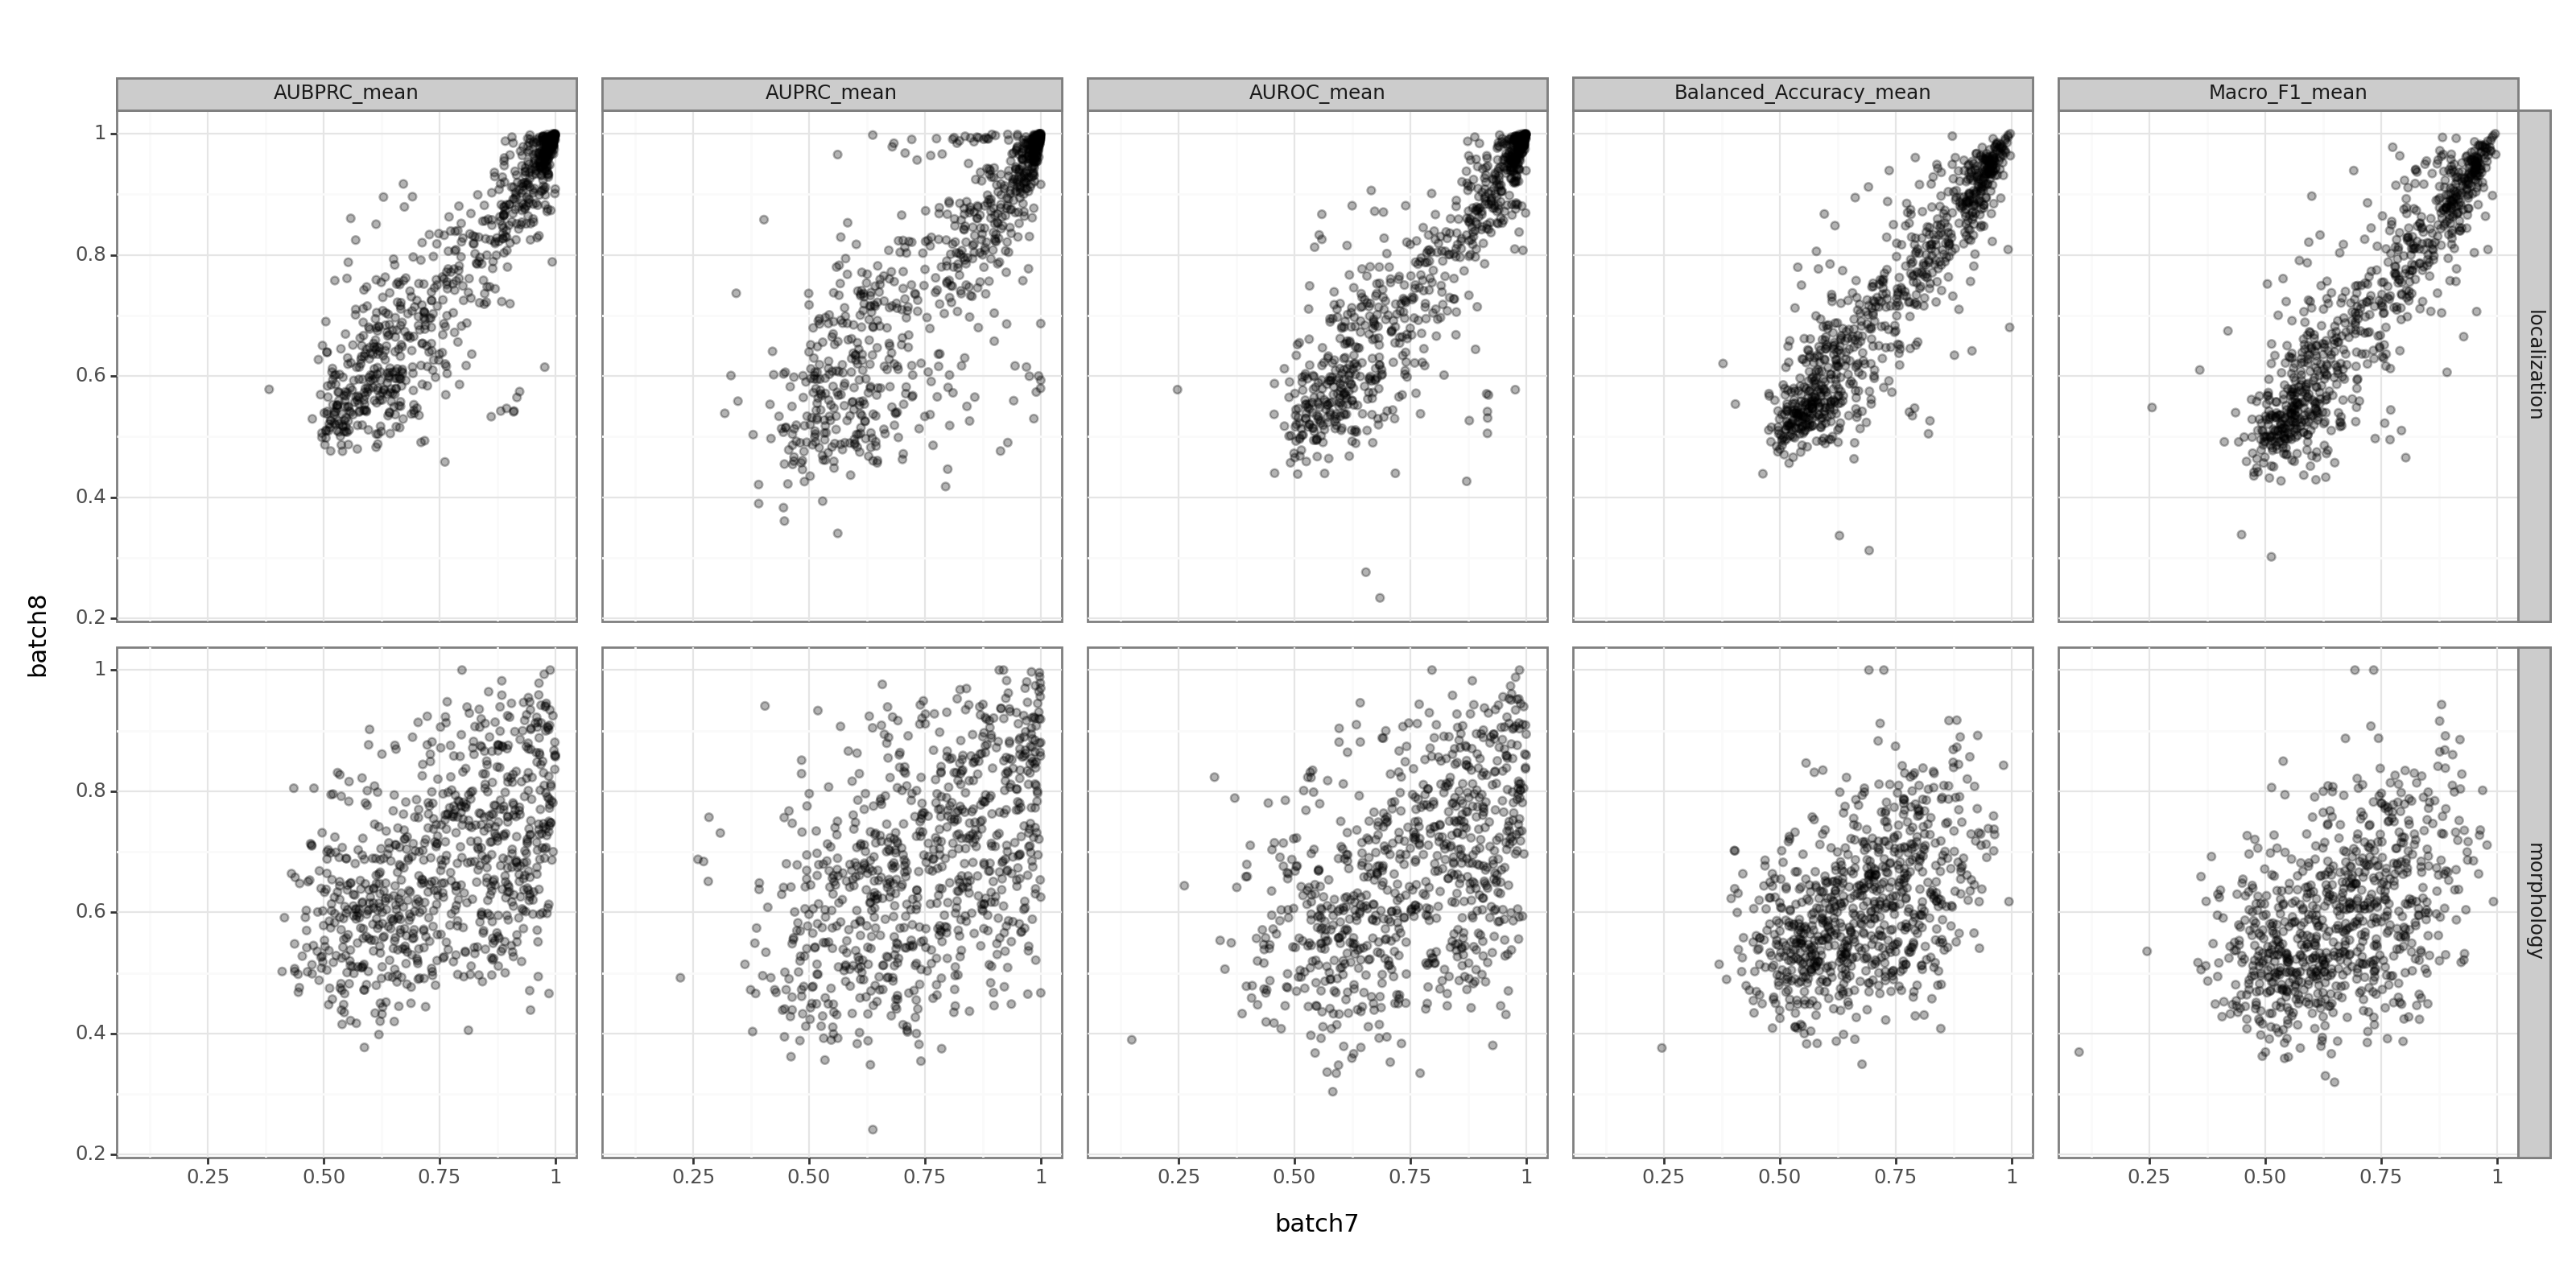

<Figure Size: (1600 x 800)>

In [155]:
plotnine.options.figure_size = (16, 8)
(ggplot(metrics_summary.filter(pl.col("Metric").str.contains("mean")), aes(x="batch7", y="batch8"))
 + geom_point(alpha=0.3)
 + theme_bw()
 + facet_grid("Classifier_type ~ Metric", "free"))

Macro-averaged F1 score has the highest consistency across batches. Filtering to exclude classifiers with imbalanced classes prior to computing the batch-aggregated metrics improves consistency across batches. 

Even for macro-averaged F1 scores, there are a small number of classifiers with very inconsistent metrics across batch. Should we filter these out because they do not replicate? And then take the mean across batches?

In [37]:
thresh = 5
metrics_ctrl = metrics_df.filter(
    (pl.col("Training_imbalance") < thresh)
    & (pl.col("Metadata_Control") == True)
).select(["Classifier_type", "Macro_F1"]).group_by("Classifier_type").quantile(0.99)

metrics_ctrl

shape: (2, 2)
┌─────────────────┬──────────┐
│ Classifier_type ┆ Macro_F1 │
│ ---             ┆ ---      │
│ str             ┆ f64      │
╞═════════════════╪══════════╡
│ morphology      ┆ 0.968324 │
│ localization    ┆ 0.742914 │
└─────────────────┴──────────┘

In [38]:
metrics_wtvar = metrics_df.filter(
    (pl.col("Training_imbalance") < thresh)
    & (pl.col("Metadata_Control") == False)
    ).select([
 'AUROC',
 'AUPRC',
 'AUBPRC',
 'Macro_F1',
 'Balanced_Accuracy',
 'Classifier_type',
 'allele_0',
]).group_by(['Classifier_type','allele_0']).agg([
    pl.all().exclude(['Classifier_type', 'allele_0']).mean().suffix('_mean')
])

In [126]:
metrics_wtvar.write_csv(f"{metrics_dir}/metrics_summary.csv")

In [39]:
morph_wtvar = metrics_wtvar.filter(pl.col("Classifier_type") == "morphology")
local_wtvar = metrics_wtvar.filter(pl.col("Classifier_type") == "localization")

print(morph_wtvar.filter(pl.col("Macro_F1_mean") > 0.97).shape[0]/morph_wtvar.shape[0])
print(local_wtvar.filter(pl.col("Macro_F1_mean") > 0.74).shape[0]/local_wtvar.shape[0])

0.01714898177920686
0.4705251875669882


In [111]:
# View images from top classifiers
local_wtvar = local_wtvar.sort(pl.col("Macro_F1_mean"), descending=True)

# concatenate all platemaps
pms = ["B7A1R1_P1.txt", "B7A1R1_P2.txt", "B7A1R1_P3.txt", "B7A1R1_P4.txt", "B7A2R1_P1.txt", "B8A1R2_P1.txt", "B8A1R2_P2.txt", "B8A1R2_P3.txt", "B8A1R2_P4.txt", "B8A2R2_P1.txt"]

pm_dfs = []
for pm in pms:
    try:
        temp = pl.read_csv(f"{pm_dir}/{pm}", separator="\t").select(['plate_map_name', 'well_position', 'control_type', 'gene_allele'])
        pm_dfs.append(temp)
    except Exception as e:
        print("Error reading {pm}: {e}")
    
pm_df = pl.concat(pm_dfs).rename({"well_position": "Well", "plate_map_name": "Plate", "gene_allele": "Allele"}).with_columns(
    pl.lit("05").alias("Site"),
    pl.col("Plate").str.slice(0,6).alias("Batch")
)

rep_df = pl.DataFrame({
    "Batch": ["B7A1R1", "B7A1R1", "B7A1R1", "B7A1R1", 
              "B7A2R1", "B7A2R1", "B7A2R1", "B7A2R1", 
              "B8A1R2", "B8A1R2", "B8A1R2", "B8A1R2",
              "B8A2R2", "B8A2R2", "B8A2R2", "B8A2R2"],
    "Replicate": ["T1", "T2", "T3", "T4",
                  "T1", "T2", "T3", "T4",
                  "T1", "T2", "T3", "T4",
                  "T1", "T2", "T3", "T4"]
})

pm_df = pm_df.join(rep_df, on="Batch")


In [ ]:
ind = 0
var_allele = local_wtvar.select("allele_0").to_series().to_list()[ind]
wt_allele = var_allele.split("_")[0]
plot_img = pm_df.filter(((pl.col("Allele") == var_allele) | (pl.col("Allele") == wt_allele))).unique().sort(["Allele", "Batch", "Replicate"])
nrow = int(round(plot_img.shape[0]/4))

di.plotMultiImages(plot_img, "GFP", 0.99, nrow, display=True)
di.plotMultiImages(plot_img, "Mito", 0.99, nrow, display=True)

In [ ]:
var_alleles = local_wtvar.select("allele_0").to_series().to_list()
plot_dir = "/dgx1nas1/storage/data/jess/varchamp/images/B7B8_1percent_wtvar"

for var_allele in var_alleles:
    gfp_nm = f"{var_allele}_GFP.png"
    mito_nm = f"{var_allele}_Mito.png"
    
    wt_allele = var_allele.split("_")[ind]
    plot_img = pm_df.filter(((pl.col("Allele") == var_allele) | (pl.col("Allele") == wt_allele))).unique().sort(["Allele", "Batch", "Replicate"])

    di.plotMultiImages(plot_img, "GFP", 0.99, 4, display=False, plotpath=f"{plot_dir}/{gfp_nm}")
    di.plotMultiImages(plot_img, "Mito", 0.99, 4, display=False, plotpath=f"{plot_dir}/{mito_nm}")